In [15]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from konlpy.tag import Okt
import random
import warnings
import json
warnings.filterwarnings("ignore")

In [16]:
pd.options.display.max_colwidth

50

In [17]:
data_1 = pd.read_csv("dataset1.csv")
# data_1

In [18]:
okt = Okt()
import re
#숫자를 공백으로 변환
data_1["body"] = data_1["body"].apply(lambda x : re.sub("r\d+"," ", x))
#필요없는 문자제거
data_1["body"] = data_1["body"].str.replace("&nbsp", " ")
data_1["body"] = data_1["body"].str.replace("~", " ")
data_1["body"] = data_1["body"].str.replace(".", " ")
data_1["body"] = data_1["body"].str.replace("&", " ")
data_1["body"] = data_1["body"].str.replace("lsquo", " ")
data_1["body"] = data_1["body"].str.replace("lt", " ")
data_1["body"] = data_1["body"].str.replace("gt", " ")


def tagging(string):
    tagged_list = okt.pos(string) 
    
    if random.uniform(0,1) < 1e-3 and len(tagged_list) >= 5:
        print('--------------------')
        print('교정전 리뷰\n',string)
        print('\n교정후 리뷰\n','/'.join([x for x,y in tagged_list]))
        
    return tagged_list

tagged_review = data_1["body"].apply(tagging)

--------------------
교정전 리뷰
 사람 생사가 왔다갔다하는데X발 시리즈 올리고 쳐 웃기다고 쪼개고있고이미 원숭이로 환생했을듯 이러면서 킥킥대네니가 사람X끼면 할 말 안 할 말 좀 가려서 해라뇌가 필터링이 안되냐?

교정후 리뷰
 사람/생사/가/왔다/갔다하는데/X/발/시리즈/올리고/쳐/웃기다고/쪼개고있고/이미/원숭이/로/환생했을듯/이러면서/킥킥대네니가/사람/X/끼/면/할/말/안/할/말/좀/가려서/해/라/뇌/가/필터/링/이/안되냐/?
--------------------
교정전 리뷰
 친구 샀다길래 5판넘게 붙었는데 덕배 패마가 초라해지네여ㅋㅋㅋ콘 램파드 살라는데 주공 지단보다 위것죠

교정후 리뷰
 친구/샀다길래/5/판/넘게/붙었는데/덕배/패마/가/초라해/지네/여/ㅋㅋㅋ/콘/램파드/살라는데/주/공/지단/보다/위것/죠
--------------------
교정전 리뷰
 진짜 마음에딱들면 바로쏨  없으면 무효 현재 제스쿼드임 4222고  케디라,지단,날두,호돈,바란 5명은 바꿀말음없고밀란마드리드OR첼마드리드로 스쿼드 야무지게 짜주시고 마음에들면 쪽지남길게요

교정후 리뷰
 진짜/마음/에/딱/들면/바로/쏨/없으면/무효/현재/제스/쿼드/임/4222/고/케디/라/,/지단/,/날/두/,/호돈/,/바란/5/명/은/바꿀말음/없고/밀란/마드리드/OR/첼/마드리드/로/스쿼드/야무지게/짜주시고/마음/에/들면/쪽지/남길게요
--------------------
교정전 리뷰
 이제 돈 풀린애들도 챔스 사재기로 눈 돌아갈거고내가 사놓은 오블락도 이제 상승곡선 시작됨다른 애들이 매물 찾기전에 먼저 발 담구길 추천

교정후 리뷰
 이제/돈/풀린/애/들/도/챔스/사재기/로/눈/돌아갈거고내가/사놓은/오/블락/도/이제/상승/곡선/시작/됨/다른/애/들/이/매물/찾기전에/먼저/발/담구길/추천
--------------------
교정전 리뷰
 너무자랑하고싶어서요  두달존버 너무힘들었거든요  ㅠㅜ사재기보다 어려운게 처분할타이밍인거같아요 , 피3땐 구단 2 2조 찍었고 현질2500정도

--------------------
교정전 리뷰
 피갤러가 올린 분데스리가 21토츠 명단 정리글인데글쓰신분도 잘 모르시는지 ?을 붙였음영어이름을 알아야하는데 혹시 분데스 아시는분 혹시 있나요??  

교정후 리뷰
 피/갤러가/올린/분데스리가/21/토츠/명단/정리/글/인데/글/쓰신/분도/잘/모르시는지/?/을/붙였음/영어/이름/을/알아야하는데/혹시/분/데스/아시/는/분/혹시/있나요/??


In [19]:
#딕셔너리 형태로 만들기 위해 join
tagged_review_joined = [["('%s','%s')"%(x,y) for x,y in review] for review in tagged_review]

review_model = Word2Vec(tagged_review_joined, vector_size=200, window = 5, workers=6,  sg=1)


review_vector = review_model.wv
review_vocab = review_vector.key_to_index

# 각 토큰에 해당하는 개수를 갖는 딕셔너리 재생성
new_dict = {}
for key, values in review_vocab.items():
    new_dict[key] = review_vector.get_vecattr(key,"count")

# new_dict

In [28]:
# KNU 한국어 감성사전 코드 일부참조
# KNU 한국어 감성사전을 참고해 단어의 극성값을 구함.
# KNU 한국어 감성사전에 내가 생각했을때 명확히 구별되는 언어를 더 추가하였음.

new_list = []
new_list_word = []
with open('SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
    data = json.load(f)
    result = ['None','None']
    
    for i in range(0, len(data)):
            for n_dict in new_dict.keys():
                if data[i]['word'] in n_dict:
                    result.pop()
                    result.pop()
                    result.append(data[i]['word_root'])
                    result.append(data[i]['polarity'])
                    
            r_word = result[0]
            s_word = result[1]
            
            #원본에 있는 데이터를 감성사전에 기반하여 그에맞는 단어 추출
            new_list_word.append(r_word)
            new_list.append(s_word) 
            
new_list
# new_list_word

['None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 '1',
 '1',
 '1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '-2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 

### 감성사전 수치에 따른 각 감정의 비율 도출

In [21]:
# 아주 좋음 리스트 개수
very_good_list = []
for very_good in new_list:
    if very_good== "2":
        very_good_list.append(very_good)
        
very_good_count = very_good_list.count("2")
        
# #좋음 리스트와 개수
good_list = []
for good in new_list:
    if good == "1":
        good_list.append(good)
        
good_count = good_list.count("1")

#보통 list 와 개수
soso_list = []
for soso in new_list:
    if soso == "0":
        soso_list.append(soso)

soso_count = soso_list.count("0")
        
# #싫음 리스트와 개수
bad_list = []
for bad in new_list:
    if bad == "-1":
        soso_list.append(bad)

bad_count = soso_list.count("-1")
bad_count

# 아주 싫음 리스트와 개수
very_sad_list = []
for sad in new_list:
    if sad == "-2":
        very_sad_list.append(sad)

very_sad_count = very_sad_list.count("-2")
very_sad_count

#전체 개수
total_emotion_count = very_good_count + good_count + soso_count + bad_count + very_sad_count

#각 감정의 비율을 계산
very_good_percent = (very_good_count / total_emotion_count) * 100
good_percent = (good_count / total_emotion_count) * 100
soso_percent = (soso_count / total_emotion_count) * 100
bad_percent = (bad_count / total_emotion_count) * 100
very_sad_percent = (very_sad_count / total_emotion_count) * 100


print("아주좋음 :",very_good_percent)
print("좋음 :", good_percent)
print("보통 :",soso_percent)
print("싫음 :", bad_percent)
print("아주싫음 :",very_sad_percent)

아주좋음 : 17.200242636651613
좋음 : 25.73970479207387
보통 : 3.2284154478668197
싫음 : 28.73222349531577
아주싫음 : 25.09941362809193


### 감정 데이터 시각화

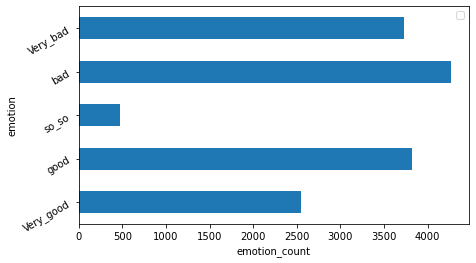

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize= (7,4))
plt.xlabel("emotion_count"); plt.ylabel('emotion')
plt.legend("good")
chart = pd.Series([very_good_count ,good_count,soso_count,bad_count,very_sad_count],\
                 index = ["Very_good","good","so_so","bad","Very_bad"]).plot(kind = "barh", rot = "30")

In [23]:
# new_list 를 데이터 프레임으로 변환하기 위해 2차원으로 변환
import numpy as np

# 리스트 형태의 데이터를 넘파이로 변환
new_list = np.array(new_list)

# 2차원으로 변환
new_list = new_list.reshape(-1,1)

# 감성사전에 기반한 데이터만 뽑아내기 위해 14844 개의 데이터만 사용

new_data = data_1.head(14851)

#new_data에 타겟값 추가
new_data["label"] = new_list

# None 값은 0(보통) 으로 치환
new_data["label"] = new_data["label"].str.replace("None", "0")

# tltle drop
new_data= new_data.drop("title", axis = 1)

# 데이터 분포 확인
# new_data["label"].value_counts()

In [24]:
# 데이터 타입 변환
from sklearn.preprocessing import LabelEncoder

#LabelEncoding 수행
features = ["date", "community","postId", "viewCount", "commentCount","body"]
for feature in features:
    new_data[[feature]] = new_data[[feature]].apply(LabelEncoder().fit_transform)
    
new_data

,date,community,postId,body,viewCount,commentCount,label
0,0,1,6085,1015,127,0,0
1,0,1,13805,13415,92,1,0
2,0,1,10640,13980,16,11,0
3,0,1,10696,2548,32,0,0
4,0,0,522,11243,29,6,0
...,...,...,...,...,...,...,...
14846,150,1,14622,907,186,2,-2
14847,151,1,14644,222,102,3,1
14848,151,1,6104,7627,78,27,1
14849,151,1,6140,8006,22,3,2


### 모델 학습 및 예측수행

In [25]:
# 학습/검증용 분리
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

feature = new_data.drop("label", axis = 1)
label = new_data["label"].astype("int")

X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size = 0.2)

In [26]:

def estimator_(X_train = None, X_val = None, y_train = None, y_val = None ):
    # 결정트리
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_val)
    
    dt_accuracy = accuracy_score(y_val, pred)
    dt_precision_score = precision_score(y_val, pred, average='macro')
    dt_recall = recall_score(y_val, pred, average='macro')
    
    #로지스틱 회귀
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    pred = lr_clf.predict(X_val)
    
    lr_accuracy = accuracy_score(y_val, pred)
    lr_precision_score = precision_score(y_val, pred, average='macro')
    lr_recall_score =  recall_score(y_val, pred, average='macro')
    
    
    #RandomForest
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    pred = rf_clf.predict(X_val)
    
    rf_accuracy = accuracy_score(y_val, pred)
    rf_precision_score = precision_score(y_val, pred, average='macro')
    rf_recall_score =  recall_score(y_val, pred, average='macro')
    
    
    print("결정트리 정확도",dt_accuracy,"\n로지스틱 회귀 정확도 ",lr_accuracy,"\n랜덤 포레스트 정확도",rf_accuracy)
    print("-------------------")
    print("결정트리 정밀도",dt_precision_score,"\n로지스틱 회귀 정밀도 ",lr_precision_score,"\n랜덤 포레스트 정밀도",rf_precision_score)
    print("-------------------")
    print("결정트리 재현율",dt_recall,"\n로지스틱 회귀 재현율 ",lr_recall_score,"\n랜덤 포레스트 재현율", rf_recall_score)
    
estimator_(X_train, X_val, y_train, y_val)

결정트리 정확도 0.5765735442611916 
로지스틱 회귀 정확도  0.2918209357118815 
랜덤 포레스트 정확도 0.5143049478290138
-------------------
결정트리 정밀도 0.5727706759934937 
로지스틱 회귀 정밀도  0.1680531103851795 
랜덤 포레스트 정밀도 0.5315915359858012
-------------------
결정트리 재현율 0.5663437170572369 
로지스틱 회귀 재현율  0.2143209674758523 
랜덤 포레스트 재현율 0.4599241534895614


### 가장 좋은 성능을 가진 결정트리로 시각화

### GraphViz로 시각화